# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import tools.davinci as dv
import tools.metrics as ms
import pandas as pd

from rdp import rdp
from tools.detector import YoloDetector, MoveNetDetector, PoseLandmarkerDetector
from tools.extractor import Extractor
from tools.structures import Skeleton

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

# Uncomment the line below to extract frames from the videos
# extractor.extract_frames()

### Skeleton Joints Extraction

To extract keypoints, different approaches will be used such as YOLO-Pose, DeepPose and OpenPose. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

In [4]:
EXAMPLE_IMAGE_PATH = "assets/frames/aJKL0ahn1Dk_20.jpg"

#### YOLO-Pose

In [5]:
yolo_detector = YoloDetector("models/yolov8x-pose-p6.pt")

# Uncomment lines below to apply YOLO detector to the frames
# keypoints = yolo_detector.detect_multi(df, "assets/frames")
# yolo_df = pd.concat(keypoints, ignore_index=True)
# yolo_df.to_csv("assets/annotations/yolo_keypoints.csv", index=False)

yolo_df = pd.read_csv("assets/annotations/yolo_keypoints.csv")
yolo_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,803.315979,173.557571,835.515747,148.530548,783.055054,145.369812,879.411865,173.806686,757.570801,163.862640,...,695.001770,688.964600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,804.176758,173.216003,835.653809,147.682251,782.198486,145.796295,878.665039,173.041428,754.971069,165.978302,...,691.973938,694.487122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,805.239990,169.009888,836.457214,143.686768,782.505249,142.022675,877.768127,170.935852,753.729370,164.452728,...,695.380554,695.014038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,805.590393,172.032562,835.968811,146.862885,780.613586,146.146515,877.941833,173.451324,752.341492,171.449234,...,690.252319,686.663513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,787.117676,165.914810,817.990356,138.446503,763.025269,141.949539,868.388611,162.747101,740.108887,168.018570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



image 1/1 /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_20.jpg: 768x1280 1 person, 1637.4ms
Speed: 3.5ms preprocess, 1637.4ms inference, 160.0ms postprocess per image at shape (1, 3, 768, 1280)
Joints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [767.4102783203125, 169.31507873535156]
Left Eye: [798.081787109375, 139.41561889648438]
Right Eye: [745.3248901367188, 144.68698120117188]
Left Ear: [857.3462524414062, 159.96923828125]
Right Ear: [729.2565307617188, 170.4316864013672]
Left Shoulder: [922.586669921875, 353.650634765625]
Right Shoulder: [667.5756225585938, 354.9814147949219]
Left Elbow: [941.002197265625, 594.3594970703125]
Right Elbow: [631.1907958984375, 582.4844360351562]
Left Wrist: [906.1353149414062, 570.2338256835938]
Right Wrist: [544.1525268554688, 586.3998413085938]
Left Hip: [nan, nan]
Right Hip: [689.5032348632812, 685.9583129882812]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Left Ankle: [nan, nan]
Rig

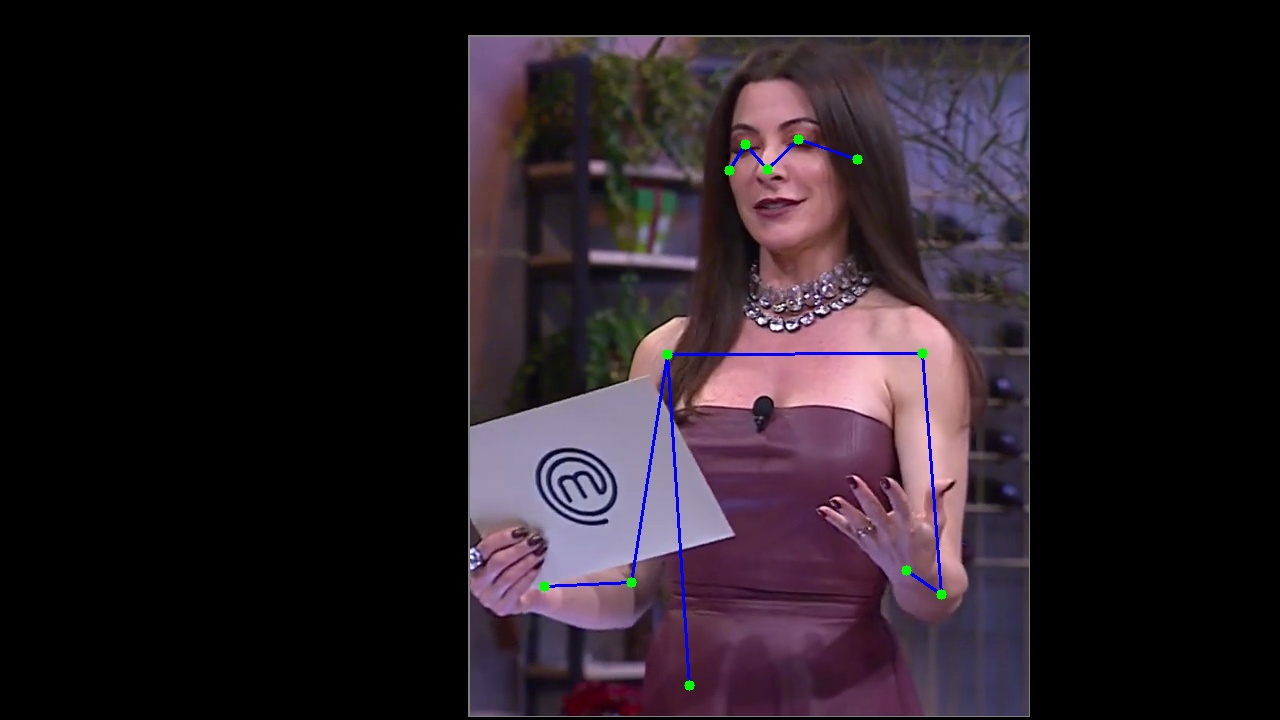

In [6]:
# Example of how a skeleton looks like
result = yolo_detector.detect(EXAMPLE_IMAGE_PATH)
print(result)
dv.draw(result, inline=True)

#### MoveNet

In [7]:
movenet_detector = MoveNetDetector("lightning")

# Uncomment lines below to apply MoveNet detector to the frames
# keypoints = movenet_detector.detect_multi(df, "assets/frames")
# movenet_df = pd.concat(keypoints, axis=1, ignore_index=True).T
# movenet_df.to_csv("assets/annotations/movenet_keypoints.csv", index=False)

movenet_df = pd.read_csv("assets/annotations/movenet_keypoints.csv")
movenet_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,798.434601,171.788353,839.572601,151.494362,768.469696,147.664694,883.934555,177.981251,744.240112,170.097048,...,683.769531,638.729110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,799.262924,171.033987,841.061096,151.012831,768.369904,146.848648,885.828857,178.007441,743.087616,169.363668,...,681.658630,655.905590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,797.994690,164.389780,839.317856,145.981822,767.926254,143.066486,881.477203,173.334593,741.144257,165.809784,...,684.390564,645.246878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,797.490158,171.685259,836.839981,149.894757,767.027588,148.734777,879.818954,173.152846,739.764557,170.265276,...,680.073471,651.498442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,786.974945,166.934295,826.663437,144.017833,755.357513,143.959157,874.286728,166.885672,728.797226,164.895709,...,683.938217,622.532558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Joints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [772.9037475585938, 163.7665843963623]
Left Eye: [809.8652648925781, 143.36461901664734]
Right Eye: [743.0837249755859, 143.7756085395813]
Left Ear: [856.5431976318359, 163.63925457000732]
Right Ear: [723.7496185302734, 160.30524730682373]
Left Shoulder: [901.3954925537109, 314.0595531463623]
Right Shoulder: [688.4443664550781, 309.60352420806885]
Left Elbow: [923.3480834960938, 476.28337383270264]
Right Elbow: [671.1766052246094, 452.3357963562012]
Left Wrist: [940.0527191162109, 563.2571983337402]
Right Wrist: [593.7876510620117, 574.813871383667]
Left Hip: [835.0155639648438, 579.6556234359741]
Right Hip: [693.0622863769531, 573.8630390167236]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Left Ankle: [nan, nan]
Right Ankle: [nan, nan]


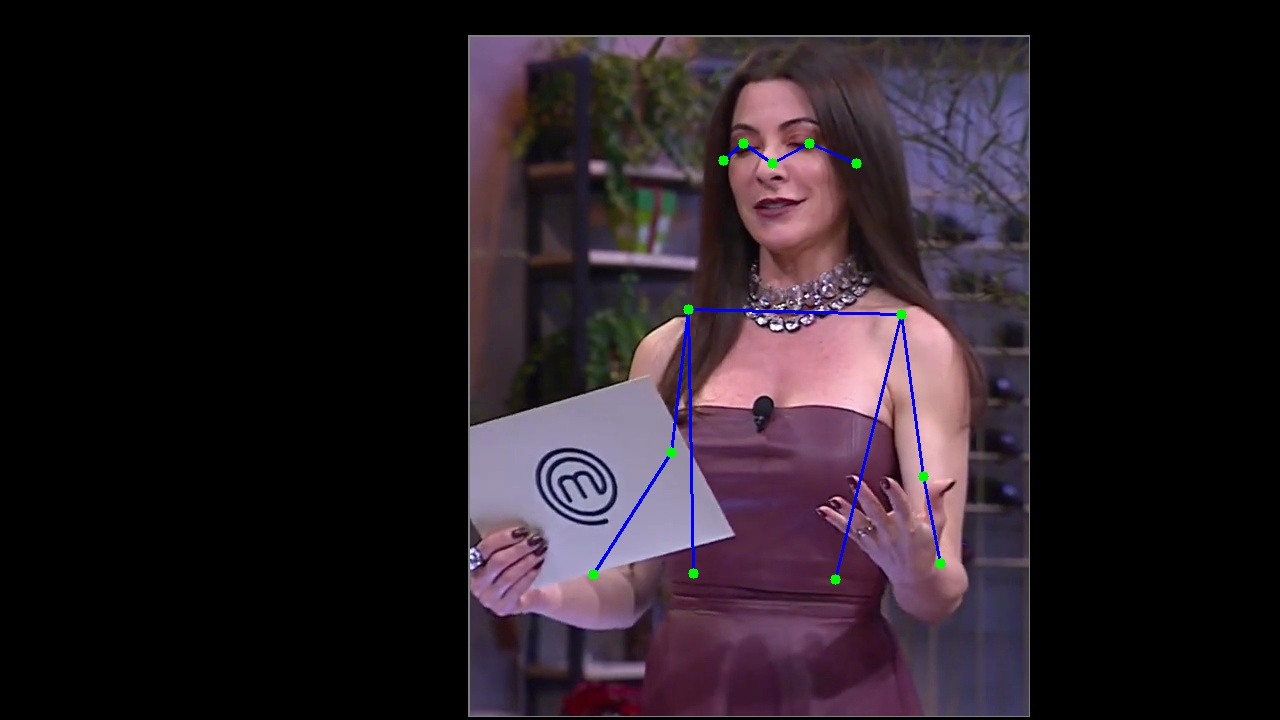

In [8]:
# Example of how a skeleton looks like
result = movenet_detector.detect(EXAMPLE_IMAGE_PATH)
print(result)
dv.draw(result, inline=True)

#### PoseLandmarker (with depth)

In [9]:
poselandmarker_detector = PoseLandmarkerDetector("models/pose_landmarker_full.task")

# Uncomment lines below to apply MoveNet detector to the frames
# keypoints = poselandmarker_detector.detect_multi(df, "assets/frames")
# poselandmarker_df = pd.concat(keypoints, axis=1, ignore_index=True).T
# poselandmarker_df.to_csv("assets/annotations/poselandmarker_keypoints.csv", index=False)

poselandmarker_df = pd.read_csv("assets/annotations/poselandmarker_keypoints.csv")
poselandmarker_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,811.567688,174.096222,841.366501,152.084599,790.503693,148.966928,869.260254,173.319283,775.243835,164.278178,...,735.863647,680.167909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,808.694992,181.475773,840.041809,159.675035,788.186035,155.363202,870.816803,180.695872,775.958557,170.310316,...,742.006912,672.522197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,810.958405,173.270273,838.753967,153.081007,786.259766,148.682613,867.834702,176.679039,768.625946,165.851798,...,731.772079,688.078923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,810.573959,178.200560,840.095444,156.902275,787.346268,151.725183,870.023499,176.784825,768.461685,167.384090,...,741.304703,666.833124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,793.814240,173.647413,819.516754,149.048295,770.276718,151.055446,851.129379,166.199799,759.724808,167.180071,...,760.392303,635.200481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Joints:
Image: assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [773.8013458251953, 175.62005996704102]
Left Eye: [804.3038177490234, 149.79403495788574]
Right Eye: [753.6943817138672, 151.67716026306152]
Left Ear: [834.9977111816406, 165.22729396820068]
Right Ear: [748.7201690673828, 166.90725803375244]
Left Shoulder: [902.0614624023438, 333.8750910758972]
Right Shoulder: [723.0253601074219, 303.8719654083252]
Left Elbow: [930.0072479248047, 556.916971206665]
Right Elbow: [641.7210388183594, 445.41449546813965]
Left Wrist: [900.7045745849609, 540.9980392456055]
Right Wrist: [568.1268310546875, 534.153470993042]
Left Hip: [848.3441925048828, 627.4261522293091]
Right Hip: [749.2924499511719, 597.698221206665]
Left Knee: [720.4017639160156, 819.8719024658203]
Right Knee: [683.9527130126953, 792.5730228424072]
Left Ankle: [nan, nan]
Right Ankle: [nan, nan]


I0000 00:00:1717374760.370536 3687821 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717374760.431487 3688109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717374760.435808 3688116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


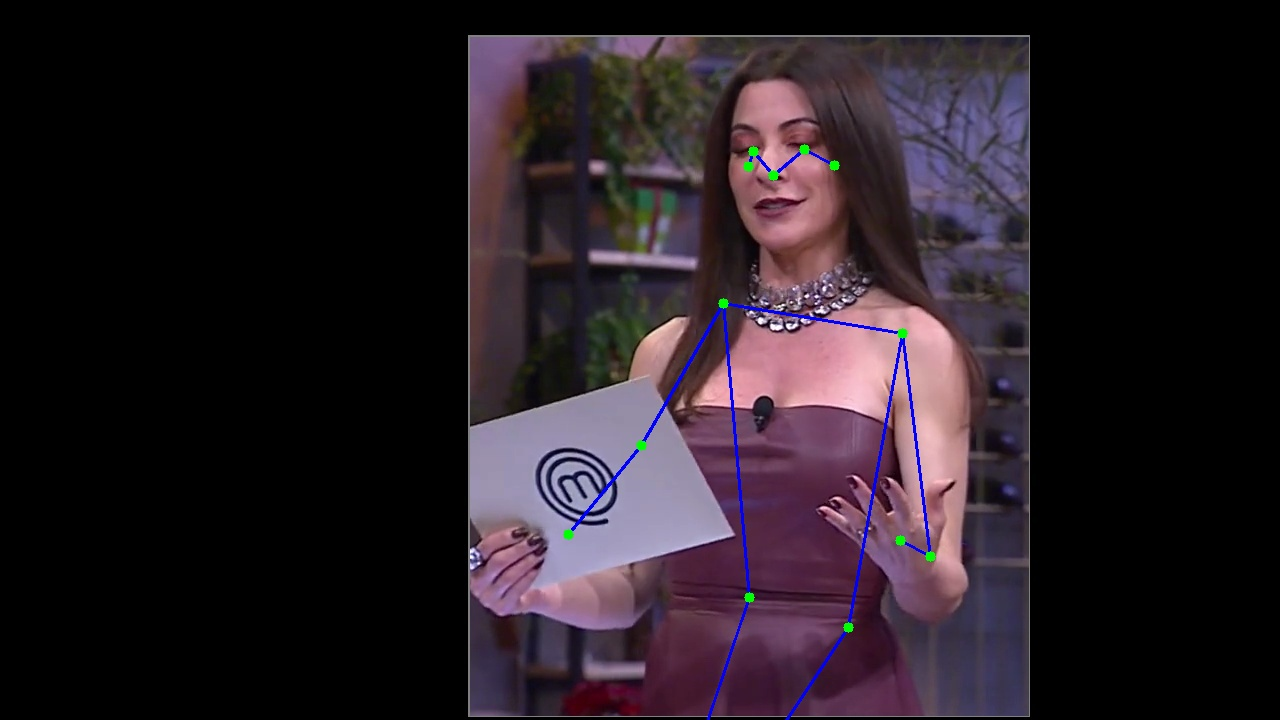

In [10]:
# Example of how a skeleton looks like
result, _ = poselandmarker_detector.detect(EXAMPLE_IMAGE_PATH)
print(result)
dv.draw(result, inline=True)

#### Combine all DataFrames

In [11]:
initial_df = pd.read_csv("assets/annotations/annotations.csv")
print("initial_df shape:", initial_df.shape)

yolo_df = pd.read_csv("assets/annotations/yolo_keypoints.csv")
yolo_merged = pd.concat([initial_df, yolo_df], axis=1)
print("yolo_merged shape:", yolo_merged.shape)

movenet_df = pd.read_csv("assets/annotations/movenet_keypoints.csv")
movenet_merged = pd.concat([initial_df, movenet_df], axis=1)
print("movenet_merged shape:", movenet_merged.shape)

poselandmarker_df = pd.read_csv("assets/annotations/poselandmarker_keypoints.csv")
poselandmarker_merged = pd.concat([initial_df, poselandmarker_df], axis=1)
print("poselandmarker_merged shape:", poselandmarker_merged.shape)

combined_df = pd.concat([yolo_merged, movenet_merged, poselandmarker_merged], axis=0).reset_index(drop=True)
print("combined_df shape:", combined_df.shape)
combined_df.head(20)
combined_df.to_csv("assets/annotations/combined_keypoints.csv", index=False)

initial_df shape: (8087, 9)
yolo_merged shape: (8087, 43)
movenet_merged shape: (8087, 43)
poselandmarker_merged shape: (8087, 43)
combined_df shape: (24261, 43)


### Normalization

#### Skeleton Normalization

At first, not all skeletons, detected on the images, have consistent position relative to the camera. Some people stand and look directly to the camera, some tilted by some unknown angle $\alpha$ around $y$-axis, so only their projection is seen on $xz$ plane; others may stand with their back. For that purpose, it may needed to rotate the skeletons around $y$-axis. However, because there is no depth information in 2D images and only $(x,y)$ coordinates given for skeleton, the <code>PoseLandmarker</code> will be used to estimate $z$ coordinate of each pixel on the image. In other words, the estimated $z$ coordinate will be transferred to the other results from other models. Then detected pixels will be aligned with existing joints coordinates and new Keypoints object with $(x,y,z)$ coordinates will be created as an output for each frame.

According to [Romero Moralis](https://openaccess.thecvf.com/content_CVPR_2019/html/Morais_Learning_Regularity_in_Skeleton_Trajectories_for_Anomaly_Detection_in_Videos_CVPR_2019_paper.html), in 2D image space, $xy$-coordinates alone poorly represent the real location in the scene because the depth is missing. However, the size of a skeleton’s bounding box is correlated with the skeleton’s depth in the scene. To bridge this gap, the skeleton's bounding box can be used (that in our case was already given in dataset) with parameters $f^g = (x^g, y^g, w, h)$ and used to normalize the local components $f^{l,i} = (x^{l,i}, y^{l,i})$. 

In [12]:
norm_skeletons = []

for index, row in combined_df.iterrows():
    start_label = "nose_X"
    row_truncated = row.loc[start_label:]
    box = (row["X"], row["Y"], row["Width"], row["Height"])
    skeleton = Skeleton.from_series(row_truncated)
    norm_skeleton = ms.normalize_skeleton(skeleton, box)
    norm_skeletons.append(norm_skeleton.to_series())

norm_skeletons_df = pd.concat(norm_skeletons, axis=1).T
norm_skeletons_df.shape

initial_dfs = pd.concat([initial_df] * 3, axis=0).reset_index(drop=True)
norm_combined_df = pd.concat([initial_dfs, norm_skeletons_df], axis=1)
print(norm_combined_df.shape)
norm_combined_df.head()

(24261, 43)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,17.218512,...,14.768906,7.215950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,17.247034,...,14.709484,7.274187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,17.280134,...,14.795581,7.279730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,17.297113,...,14.688657,7.191632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,16.904609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Cleaning

According to [Wei Tang](https://www.mdpi.com/1424-8220/22/11/4245), frames in which body parts were occluded or lost were excluded from further analysis, because the skeletons in these frames could not be detected correctly using the current 2D pose estimation algorithm. The necessary body parts will be determined as torso, left and right hands. The position of head and legs will be ommited.

In [13]:
# Remove all columns that represent legs
columns_drop = norm_combined_df.columns[norm_combined_df.columns.get_loc('right_hip_Y')+1:]
cleaned_df = norm_combined_df.drop(columns=columns_drop)

# Remove rows that have NaN values in all necessary body parts
body_parts = cleaned_df.columns[cleaned_df.columns.get_loc('right_ear_Y')+1:]
cleaned_df = cleaned_df.dropna(subset=body_parts, how='any')
# cleaned_df = cleaned_df.reset_index(drop=True)
print(cleaned_df.shape)
cleaned_df.head()

(8601, 35)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,right_elbow_X,right_elbow_Y,left_wrist_X,left_wrist_Y,right_wrist_X,right_wrist_Y,left_hip_X,left_hip_Y,right_hip_X,right_hip_Y
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,17.218512,...,12.599672,5.873517,18.755997,5.314316,12.741324,5.030417,18.127400,7.280087,14.768906,7.215950
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,17.247034,...,12.611951,5.881303,18.718189,5.526610,13.073669,5.298088,18.121116,7.319256,14.709484,7.274187
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,17.280134,...,12.560782,5.961339,18.868096,5.496667,13.108144,5.297211,18.272943,7.314235,14.795581,7.279730
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,17.297113,...,12.596624,5.958947,18.524276,5.506145,12.664761,5.292464,18.286063,7.218289,14.688657,7.191632
5,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19562,37.784539,5.104723,44.216991,94.802684,0,16.575984,...,12.689918,5.926699,16.667760,4.597321,12.159715,4.497054,18.097937,6.998804,14.857182,6.979695


#### Calculate NaN head parameters

[bla-bla-bla]

#### Segment Normalization

Before clustering, we needs to ensure that all segments have identical size:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [14]:
# segments = ms.segmentate(cleaned_df)
# print("Total number of segments:", len(segments))
# print("Original (first 5):", [segment.indices() for segment in segments])

# norm_segments = [ms.normalize_segment(segment) for segment in segments]
# norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

# norm_segments = ms.segmentate(norm_df)
# print("Total number of normalized segments:", len(norm_segments))
# print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

## Step 2: Feature Extraction

### Curve Simplification

To extract trajectory features, inspired by [Tomasz Sapiński](https://www.mdpi.com/1099-4300/21/7/646), the curve simplification (CS) algorithm, based on the Lowe's algorithm, will be applied, for 2D joints separately for each segment, that returns a set of key points that are essential for accurately representing the original curve. The algorithm will return the following:
 
- The critical frames in the motion sequence that capture significant changes in the movement.
- The simplified version of the original motion trajectory (data reduction).
- The maximum deviation error for each segment of the simplified trajectory, ensuring that the simplification process maintains a level of accuracy defined by the error threshold.

#### Posture

- Torso Angle: The angle of the torso relative to the vertical axis can indicate openness (leaning forward) or defensiveness (leaning backward).
- Head Position and Tilt: The position and tilt of the head can indicate attentiveness, interest, or submission.

#### Movement Dynamics

- Velocity and Acceleration: Speed and acceleration of keypoints, such as hands and feet, can indicate levels of agitation or calmness.
- Jerkiness of Movements: Sudden, jerky movements can indicate fear or anxiety, while smooth movements can indicate calmness or happiness.

#### Gestures:

- Hand and Arm Positions: Positions and movements of the hands and arms can indicate various emotions, such as openness (arms open) or defensiveness (arms crossed).
- Hand Gestures: Specific hand gestures, like pointing, waving, or clenching, can provide clues about the emotional state.

#### Inter-Keypoint Distances:

- Distance Between Hands and Body: Indicates openness or self-comforting behaviors.

#### Symmetry and Balance:

- Symmetry in Posture: Asymmetrical postures can indicate discomfort or defensiveness.
- Balance and Center of Mass: Shifts in the center of mass can indicate readiness to move or unease.

#### Overall Pose Estimation:

- Pose Variability Over Time: How much the overall pose changes over time can indicate restlessness or calmness.
- Pose Similarity to Known Emotional States: Comparing the detected pose to a library of poses associated with specific emotions.

#### Emotion Labeling

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a probability of a particular emotion, calculated as $i/n$, where $i$ is an emotion label and $n$ is a total number of emotions that were detected by different annotators.

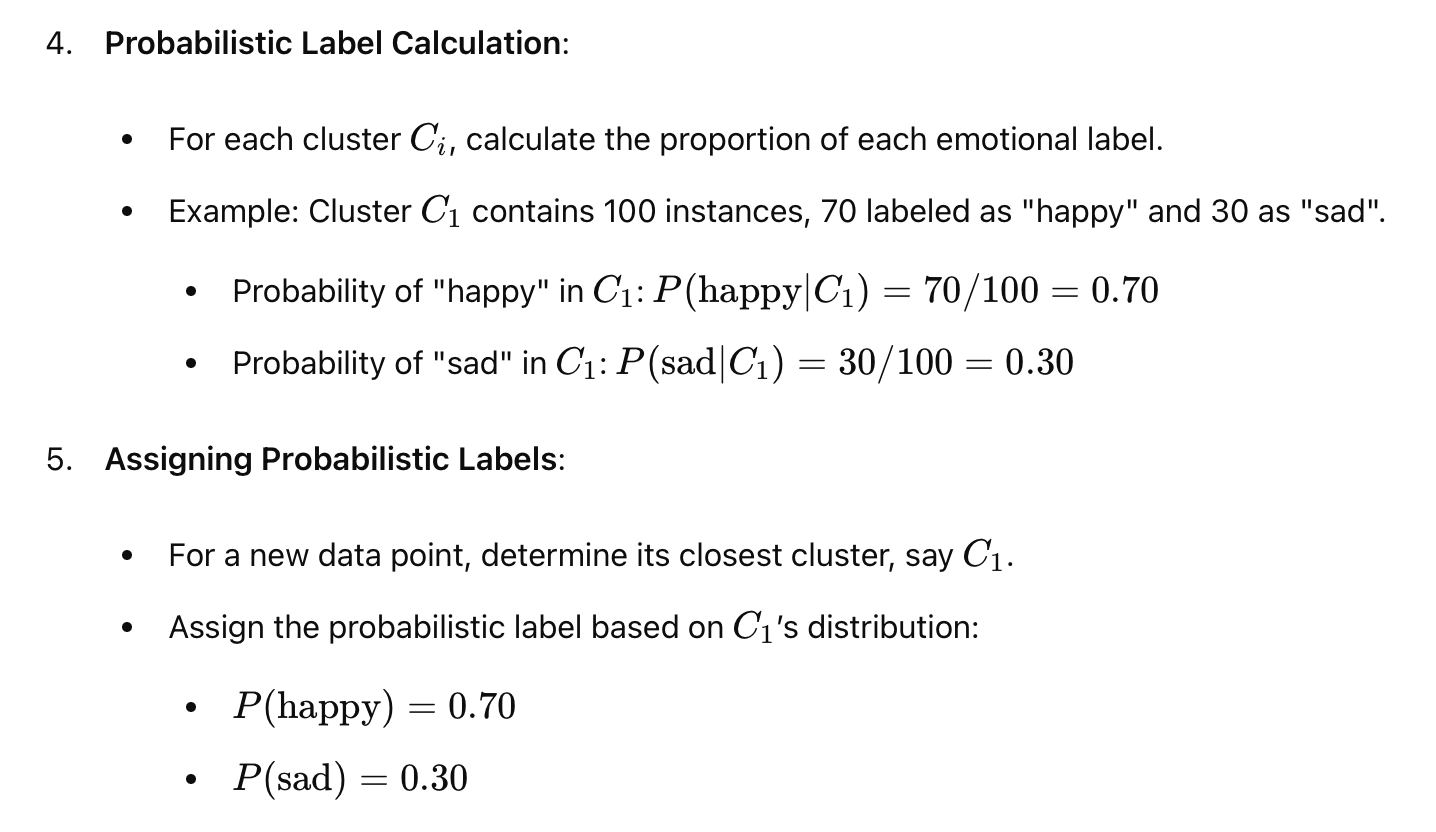

In [15]:
probs = ms.label_probabilities(df)
probs_df = pd.DataFrame(probs, columns=list(ms.Emotions.keys()))
probs_df.head()

,Happy,Sad,Fear,Neutral,Surprise,Disgust,Anger
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 3: Clustering

### Hierarchical

### X-Means

## Step 4: Evaluation

### Evaluate Clusters

### Refine Clusters